In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist
# from scipy.io import wavfile

In [2]:
# f2m = 1/3.2808
def f2m(x):
    return x*(1/3.2808)

roomX = f2m(52/3)
roomY = f2m(49/2)
roomZ = f2m(7) #not sure about this 

In [3]:
m = pra.make_materials(
    ceiling="hard_surface",
    floor="hard_surface",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
)

In [ ]:
# Use this in lab to figure out the reflection order, you'll need to guess a reverberation time
rt60_tgt = 0.3  # seconds 
room_dim = [10, 7.5, 3.5]  # meters
fs, audio = wavfile.read("examples/samples/guitar_16k.wav")
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)
# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

In [ ]:
# The desired reverberation time and dimensions of the room
# rt60_tgt = 0.3  # seconds
room_dim = [roomX, roomY, roomZ]  # meters
room = pra.ShoeBox(
    room_dim, fs=48000, materials=m, max_order=17, air_absorption=True, ray_tracing=True
)

In [33]:
azimuth = 61.0 / 180.0 * np.pi  # 60 degrees
# distance = 3.0  # 3 meters

# algorithms parameters
SNR = 0.0  # signal-to-noise ratio
c = 343.0  # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

# compute the noise variance
# sigma2 = 10 ** (-SNR / 10) / (4.0 * np.pi * distance) ** 2

# Create an anechoic room
# room_dim = np.r_[roomX, roomY, roomZ]  # meters
room_dim = np.r_[roomX, roomY]  # meters
room = pra.ShoeBox(room_dim, fs=fs, max_order=17) #Assume no noise

sourceX = roomX/2
sourceY = roomY/3
h = roomY - 2*sourceY
b = h/np.tan(azimuth)
print(f'b: {b}')
distance = np.sqrt((b**2)+(h**2))
print(f'distance: {distance}')



# add the source
# source_location = room_dim / 2 + distance * \
#     np.r_[np.cos(azimuth), np.sin(azimuth)]
source_location = np.r_[sourceX, sourceY]
print(f'source loc: {source_location}')
source_signal = np.random.randn((nfft // 2 + 1) * nfft)
room.add_source(source_location, signal=source_signal)

in_mic = 0.15
#Mics will be 0.14 m apart
mic_locs = np.c_[
    [(roomX/2)+b+(in_mic/2), roomY-sourceY],  # mic 1
    [(roomX/2)+b-(in_mic/2), roomY-sourceY],  # mic 2
]

# print(mic_locs)
print(f'In mic dist: {mic_locs[0][0] -  mic_locs[0][1]}')
print(f'Mics loc:\n{mic_locs.T}')
room.add_microphone_array(mic_locs)

room.simulate()
# room.add_microphone_array(mic_locs)

b: 1.3798028692791229
distance: 2.846071553980364
source loc: [2.64163212 2.48923027]
In mic dist: 0.15000000000000036
Mics loc:
[[4.09643499 4.97846054]
 [3.94643499 4.97846054]]


In [36]:
# Compute the STFT frames needed
X = np.array(
    [
        pra.transform.stft.analysis(signal, nfft, nfft // 2).T
        for signal in room.mic_array.signals
    ]
)

##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())

for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    # doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)
    doa = pra.doa.algorithms[algo_name](mic_locs, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)

    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print("  Recovered azimuth:", doa.azimuth_recon / np.pi * 180.0, "degrees")
    print("  Error:", circ_dist(azimuth, doa.azimuth_recon) /
          np.pi * 180.0, "degrees")

plt.show()

CSSM
  Recovered azimuth: [271.] degrees
  Error: [150.] degrees


LinAlgError: singular matrix

distance: 2.846071553980364
source loc: [2.84563808 0.0496708 ]
R:
[[2.79163212 2.77153593 2.71663212 2.64163212 2.56663212 2.51172831
  2.49163212 2.51172831 2.56663212 2.64163212 2.71663212 2.77153593]
 [3.7338454  3.8088454  3.86374921 3.8838454  3.86374921 3.8088454
  3.7338454  3.6588454  3.60394159 3.5838454  3.60394159 3.6588454 ]]
CSSM
  Recovered azimuth: [273.] degrees
  Error: [88.] degrees
FRIDA
  Recovered azimuth: [273.12967011] degrees
  Error: [87.87032989] degrees
MUSIC
  Recovered azimuth: [273.] degrees
  Error: [88.] degrees
SRP
  Recovered azimuth: [273.] degrees
  Error: [88.] degrees
TOPS
  Recovered azimuth: [273.] degrees
  Error: [88.] degrees
WAVES
  Recovered azimuth: [273.] degrees
  Error: [88.] degrees


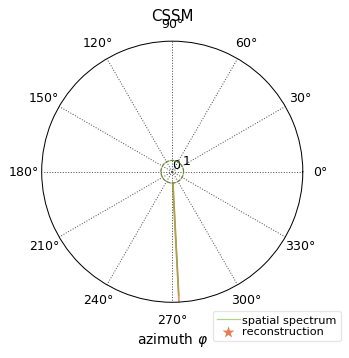

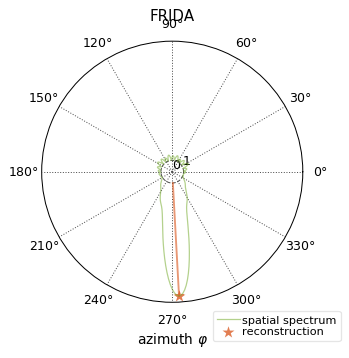

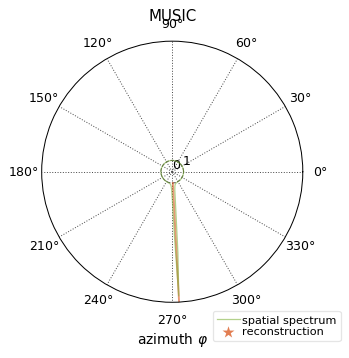

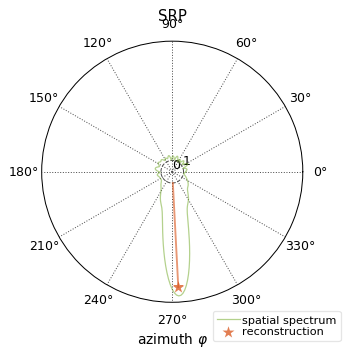

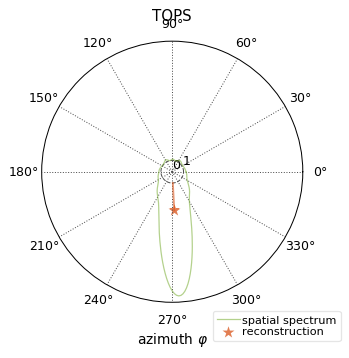

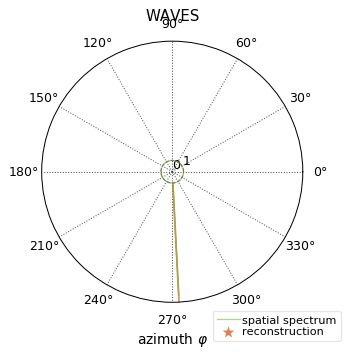

In [41]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

######
# We define a meaningful distance measure on the circle

# Location of original source
# azimuth = 61.0 / 180.0 * np.pi  # 60 degrees
azimuth = 1 / 180.0 * np.pi  # 60 degrees
distance = 3.0  # 3 meters

#######################
# algorithms parameters
SNR = 0.0  # signal-to-noise ratio
c = 343.0  # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

# compute the noise variance
sigma2 = 10 ** (-SNR / 10) / (4.0 * np.pi * distance) ** 2

roomX = f2m(52/3)
roomY = f2m(49/2)
# Create an anechoic room
room_dim = np.r_[roomX, roomY]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# add the source
# source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
# source_signal = np.random.randn((nfft // 2 + 1) * nfft)
# aroom.add_source(source_location, signal=source_signal)
source_location = np.r_[sourceX, sourceY]
print(f'source loc: {source_location}')
source_signal = np.random.randn((nfft // 2 + 1) * nfft)
aroom.add_source(source_location, signal=source_signal)

# We use a circular array with radius 15 cm # and 12 microphones
R = pra.circular_2D_array(room_dim / 2, 12, 0.0, 0.15)
print(f'R:\n{R}')
aroom.add_microphone_array(pra.MicrophoneArray(R, fs=aroom.fs))

# run the simulation
aroom.simulate()

################################
# Compute the STFT frames needed
X = np.array(
    [
        pra.transform.stft.analysis(signal, nfft, nfft // 2).T
        for signal in aroom.mic_array.signals
    ]
)

##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())

for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)

    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print("  Recovered azimuth:", doa.azimuth_recon / np.pi * 180.0, "degrees")
    print("  Error:", circ_dist(azimuth, doa.azimuth_recon) /
          np.pi * 180.0, "degrees")

plt.show()
